# Options Pricing pour un portefeuille consitué de 2 actifs

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import *
from scipy.stats import norm
import time

## 1. Méthodes numériques classiques

### 1.1 Méthodes des différences finies

Nombre de points de discrétisation en espace M = 10
Nombre de points de discrétisation en temps N = 10
CALL ou PUT 
  CALL
EE pour le schéma d'Euler Explicite 
EI pour le schéma d'Euler Implicite 
CN pour le schéma de Crank-Nicolson 
  CN
DROIT pour approcher la dérivée d'ordre 1 en temps par un schéma décentré à droite 
GAUCHE par un schéma décentré à gauche 
CENTRE par un schéma centré 
  DROIT
Erreur Linf à la date T=1 :  0.6858713069838469
Temps écoulé :  0.004848003387451172


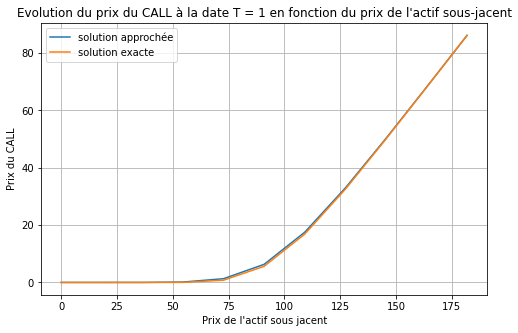

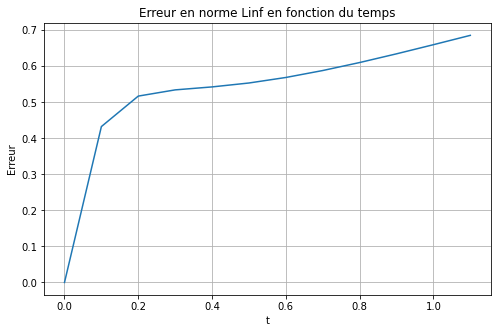

In [10]:
#-------------------------------------------------
#- DONNEES
#-------------------------------------------------
# Constantes
K = 100
sigma = 0.2
r = 0.04
T = 1
Smax = 200

#- Condition initale (Payoff)
def P0(s,K):
    if (OPTION=='PUT'):
        return np.maximum(K - s, 0)
    elif (OPTION=='CALL'):
        return np.maximum(s - K, 0)
    else:
        print('Vérifier la variable OPTION')

#- Variables d'entrée
M=int(input('Nombre de points de discrétisation en espace M = '))
N=int(input('Nombre de points de discrétisation en temps N = '))
OPTION=str(input("CALL ou PUT \n  "))
METHODE=str(input("EE pour le schéma d'Euler Explicite \nEI pour le schéma d'Euler Implicite \nCN pour le schéma de Crank-Nicolson \n  "))# 'EE' ou 'EI' ou 'CN'
CENTRAGE=str(input("DROIT pour approcher la dérivée d'ordre 1 en temps par un schéma décentré à droite \nGAUCHE par un schéma décentré à gauche \nCENTRE par un schéma centré \n  ")) # 'DROIT' ou 'GAUCHE' ou 'CENTRE'

#-------------------------------------------------
#- FORMULE DE BLACK SCHOLES : SOLUTION EXACTE
#-------------------------------------------------
def U_exacte(t, s):
    if t==0:
        return P0(s,K)
    else:
        P=np.ones(len(s))*K*np.exp(-r*t)
        i=np.where(s>0) 
        tau=sigma**2*t
        dm=(np.log(s[i] /K) + r*t - 0.5*tau) / np.sqrt(tau)
        dp=(np.log(s[i] /K) + r*t + 0.5*tau) / np.sqrt(tau)
        P[i]=K*np.exp(-r*t)*(norm.cdf(-dm)) - s[i]*(norm.cdf(-dp))
        if (OPTION=='PUT'):
            return P
        elif (OPTION=='CALL'):
            return s + P - K*np.exp(-r*t)
        else:
            print('Vérifier la variable OPTION')

#-------------------------------------------------
#- MAILLAGE
#-------------------------------------------------
dt=T/N 
h=Smax/(M+1)
stot=np.arange(0,M+2)*h
s=np.arange(0,M+1)*h

#-------------------------------------------------
#- INITIALISATION DE LA MATRICE A
#-------------------------------------------------
J = np.diag(np.ones(M),1)
L = (2*np.eye(M+1)-J-J.T)/(h**2)
a = ((sigma**2)/2)*s**2
A2 = np.dot(np.diag(a),L)

b = -r*s
if (CENTRAGE == 'DROIT'):
    A1 = np.dot(np.diag(b), -np.eye(M+1) + J)/h
elif (CENTRAGE == 'GAUCHE'):
    A1 = np.dot(np.diag(b), np.eye(M+1) - J.T)/h
elif (CENTRAGE == 'CENTRE'):
    A1 = np.dot(np.diag(b), J - J.T)/(2*h)
else:
    print('Verifier la variable CENTRAGE.')

A = A2 + A1 + r*np.eye(M+1)

#-------------------------------------------------
#- INITIALISATION DU VECTEUR V
#-------------------------------------------------
def V(t):
    if (CENTRAGE == 'DROIT'):
        a1 = 1
    elif (CENTRAGE == 'GAUCHE'):
        a1 = 0
    elif (CENTRAGE == 'CENTRE'):
        a1 = 0.5
    res = np.zeros(M+1)
    res[-1] = (Smax-K*np.exp(-r*t))*(- (sigma*s[-1])**2/(2*h**2) - a1*r*s[-1]/h)
    return res

#-------------------------------------------------
#- SOLUTION APPROCHEE
#-------------------------------------------------
start = time.time()

U_approx = np.array([P0(s,K).tolist()]*(N+2))
U_ex = np.array([U_exacte(0,s).tolist()]*(N+2))
errLI = [0]
for i in range(N+1):
    if (METHODE=='EE'):
        U_approx[i+1] = np.dot((np.eye(M+1) - dt * A), U_approx[i]) - (OPTION=='CALL')*dt*V(i*dt)
    elif (METHODE=='EI'):
        U_approx[i+1] = np.linalg.solve(np.eye(M+1) + dt * A, U_approx[i] - (OPTION=='CALL')*dt*V((i+1)*dt))
    elif (METHODE=='CN'):
        Y = np.eye(M+1) + 0.5*dt*A
        Z = np.eye(M+1) - 0.5*dt*A
        U_approx[i+1] = np.linalg.solve(Y, np.dot(Z,U_approx[i]) - (OPTION=='CALL')*0.5*dt*(V((i+1)*dt)+V((i)*dt)))

    U_ex[i+1] = U_exacte((i+1)*dt,s)
    errLI.append(np.max(np.abs(U_approx[i+1] - U_ex[i+1])))
    
end = time.time()
    
print("Erreur Linf à la date T=1 : ", errLI[-1])
print("Temps écoulé : ", end - start)

#-------------------------------------------------
#- GRAPHIQUES
#-------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(s, U_approx[-1], label='solution approchée')
plt.plot(s, U_ex[-1], label='solution exacte')
plt.title("Evolution du prix du "+OPTION+" à la date T = "+str(T)+" en fonction du prix de l'actif sous-jacent")
plt.xlabel("Prix de l'actif sous jacent")
plt.ylabel("Prix du "+OPTION)
plt.grid()
plt.legend();

# ERREUR LINF
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,N+2)*dt, errLI)
plt.title("Erreur en norme Linf en fonction du temps")
plt.ylabel("Erreur")
plt.xlabel("t")
plt.grid()
plt.show();

### 1.2 Méthodes des éléments finis

#### 1.2.1 Sans prendre en compte $u(t,0) = K e^{-rt}$ 

Nombre de points de discrétisation en espace M = 10
Nombre de points de discrétisation en temps N = 10
EE pour le schéma d'Euler Explicite 
EI pour le schéma d'Euler Implicite 
CN pour Crank-Nicolson 
  EE
Erreur Linf à la date T=1 :  0.5106988519189937
Temps écoulé :  0.005410194396972656


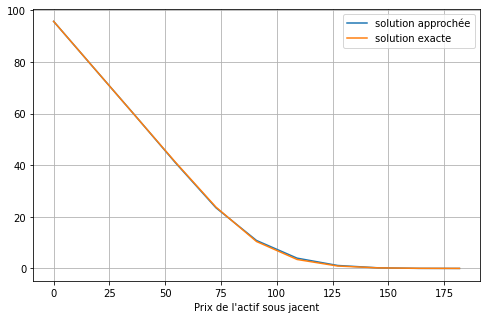

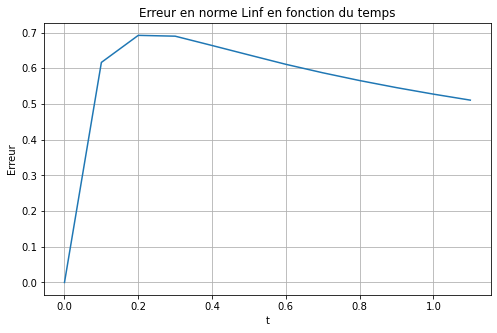

In [11]:
#-------------------------------------------------
#- DONNEES
#-------------------------------------------------
# Constantes
K = 100
sigma = 0.2
r = 0.04
T = 1
Smax = 200

#- Condition initale (Payoff)
def P0(s,K):
     return np.maximum(K - s, 0)

#- Variables d'entrée
M=int(input('Nombre de points de discrétisation en espace M = '))
N=int(input('Nombre de points de discrétisation en temps N = '))
METHODE=str(input("EE pour le schéma d'Euler Explicite \nEI pour le schéma d'Euler Implicite \nCN pour Crank-Nicolson \n  "))# 'EE' ou 'EI' ou 'CN'

#-------------------------------------------------
#- FORMULE DE BLACK SCHOLES : SOLUTION EXACTE
#-------------------------------------------------
def U_exacte(t, s):
    if t==0:
        return P0(s,K)
    else:
        P=np.ones(len(s))*K*np.exp(-r*t)
        i=np.where(s>0) 
        tau=sigma**2*t
        dm=(np.log(s[i] /K) + r*t - 0.5*tau) / np.sqrt(tau)
        dp=(np.log(s[i] /K) + r*t + 0.5*tau) / np.sqrt(tau)
        P[i]=K*np.exp(-r*t)*(norm.cdf(-dm)) - s[i]*(norm.cdf(-dp))
    return P
    

#-------------------------------------------------
#- MAILLAGE
#-------------------------------------------------
dt=T/N 
h=Smax/(M+1)
s=np.arange(0,M+1)*h
stot=np.arange(0,M+2)*h

#-------------------------------------------------
#- INITIALISATION DES MATRICES
#-------------------------------------------------
J = np.diag(np.ones(M),1)
A1 = (4*np.eye(M+1)+J+J.T)*h/6
A1[0][0] = h/3

A2 = -(np.eye(M+1)+J+J.T)*h/3 - 0.5*np.diag(s[:-1],-1) + 0.5*np.diag(s[1:],1)
A2[0][0] = -h/6

A3 = (2*np.eye(M+1)-J-J.T)*h/3 + np.dot(np.diag(s), np.diag(s)*2/h - np.diag(s[1:],1)/h - np.diag(s[:-1],-1)/h)
A3[0][0] = h/3

A4 = r*A1 + (sigma**2 - r)*A2 + 0.5*sigma**2*A3

#-------------------------------------------------
#- SOLUTION APPROCHEE
#-------------------------------------------------
start = time.time()

U_approx = np.array([P0(s,K).tolist()]*(N+2))
U_ex = np.array([U_exacte(0,s).tolist()]*(N+2))
errLI = [0]
for i in range(N+1):
    if (METHODE=='EE'):
        U_approx[i+1] = np.linalg.solve(A1, np.dot(A1-dt*A4, U_approx[i]))
    elif (METHODE=='EI'):
        U_approx[i+1] = np.linalg.solve(A1+dt*A4, np.dot(A1, U_approx[i]))
    elif (METHODE=='CN'):
        Y = A1+0.5*dt*A4
        Z = A1-0.5*dt*A4
        U_approx[i+1] = np.linalg.solve(Y, np.dot(Z, U_approx[i]))
            
    U_ex[i+1] = U_exacte((i+1)*dt,s)
    errLI.append(np.max(np.abs(U_approx[i+1] - U_ex[i+1])))
    
end = time.time()
    
print("Erreur Linf à la date T=1 : ", errLI[-1])
print("Temps écoulé : ", end - start)

#-------------------------------------------------
#- GRAPHIQUES
#-------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(s, U_approx[-1], label='solution approchée')
plt.plot(s, U_ex[-1], label='solution exacte')
# plt.title("Evolution du prix du "+OPTION+" à la date T = "+str(T)+" en fonction du prix de l'actif sous-jacent")
plt.xlabel("Prix de l'actif sous jacent")
# plt.ylabel("Prix du "+OPTION)
plt.grid()
plt.legend();

# ERREUR LINF
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,N+2)*dt, errLI)
plt.title("Erreur en norme Linf en fonction du temps")
plt.ylabel("Erreur")
plt.xlabel("t")
plt.grid()
plt.show();

#### 1.2.2 En prenant en compte $u(t,0) = K e^{-rt}$ 

Nombre de points de discrétisation en espace M = 10
Nombre de points de discrétisation en temps N = 10
EE pour le schéma d'Euler Explicite 
EI pour le schéma d'Euler Implicite 
CN pour Crank-Nicolson 
  EE
Erreur Linf à la date T=1 :  0.5106993382843856
Temps écoulé :  0.0036780834197998047


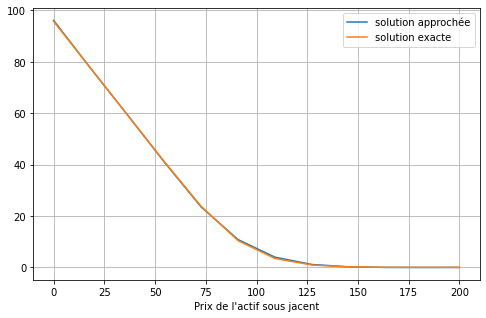

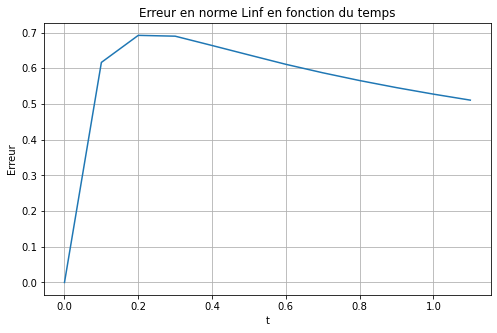

In [13]:
#-------------------------------------------------
#- DONNEES
#-------------------------------------------------
# Constantes
K = 100
sigma = 0.2
r = 0.04
T = 1
Smax = 200

#- Condition initale (Payoff)
def P0(s,K):
     return np.maximum(K - s, 0)

#- Variables d'entrée
M=int(input('Nombre de points de discrétisation en espace M = '))
N=int(input('Nombre de points de discrétisation en temps N = '))
METHODE=str(input("EE pour le schéma d'Euler Explicite \nEI pour le schéma d'Euler Implicite \nCN pour Crank-Nicolson \n  "))# 'EE' ou 'EI' ou 'CN'

#-------------------------------------------------
#- FORMULE DE BLACK SCHOLES : SOLUTION EXACTE
#-------------------------------------------------
def U_exacte(t, s):
    if t==0:
        return P0(s,K)
    else:
        P=np.ones(len(s))*K*np.exp(-r*t)
        i=np.where(s>0) 
        tau=sigma**2*t
        dm=(np.log(s[i] /K) + r*t - 0.5*tau) / np.sqrt(tau)
        dp=(np.log(s[i] /K) + r*t + 0.5*tau) / np.sqrt(tau)
        P[i]=K*np.exp(-r*t)*(norm.cdf(-dm)) - s[i]*(norm.cdf(-dp))
    return P
    

#-------------------------------------------------
#- MAILLAGE
#-------------------------------------------------
dt=T/N 
h=Smax/(M+1)
s=np.arange(1,M+1)*h
stot=np.arange(0,M+2)*h

#-------------------------------------------------
#- INITIALISATION DES MATRICES
#-------------------------------------------------
J = np.diag(np.ones(M-1),1)
A1 = (4*np.eye(M)+J+J.T)*h/6

A2 = -(np.eye(M)+J+J.T)*h/3 - 0.5*np.diag(s[:-1],-1) + 0.5*np.diag(s[1:],1)

A3 = (2*np.eye(M)-J-J.T)*h/3 + np.dot(np.diag(s), np.diag(s)*2/h - np.diag(s[1:],1)/h - np.diag(s[:-1],-1)/h)

A4 = r*A1 + (sigma**2 - r)*A2 + 0.5*sigma**2*A3

def f(t):
    res = np.zeros(M)
    res[0] = K*np.exp(-r*t)*h*(3*sigma**2 - 2*r)/6
    return res

#-------------------------------------------------
#- SOLUTION APPROCHEE
#-------------------------------------------------
start = time.time()

U_approx = np.array([P0(s,K).tolist()]*(N+2))
U_ex = np.array([U_exacte(0,stot).tolist()]*(N+2))
errLI = [0]
for i in range(N+1):
    if (METHODE=='EE'):
        U_approx[i+1] = np.linalg.solve(A1, np.dot(A1-dt*A4, U_approx[i]) + dt*f(i*dt))
    elif (METHODE=='EI'):
        U_approx[i+1] = np.linalg.solve(A1+dt*A4, np.dot(A1, U_approx[i]) + dt*f((i+1)*dt))
    elif (METHODE=='CN'):
        Y = A1+0.5*dt*A4
        Z = A1-0.5*dt*A4
        U_approx[i+1] = np.linalg.solve(Y, np.dot(Z, U_approx[i]) + dt*0.5*(f(i*dt)+f((i+1)*dt)))
            
        
    U_ex[i+1] = U_exacte((i+1)*dt,stot)
    errLI.append(np.max(np.abs(U_approx[i+1] - U_ex[i+1,1:-1])))
    
end = time.time()
    
print("Erreur Linf à la date T=1 : ", errLI[-1])
print("Temps écoulé : ", end - start)

#-------------------------------------------------
#- GRAPHIQUES
#-------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(stot, [K*np.exp(-r*T)] + U_approx[-1].tolist() + [0], label='solution approchée')
plt.plot(stot, U_ex[-1], label='solution exacte')
# plt.title("Evolution du prix du "+OPTION+" à la date T = "+str(T)+" en fonction du prix de l'actif sous-jacent")
plt.xlabel("Prix de l'actif sous jacent")
# plt.ylabel("Prix du "+OPTION)
plt.grid()
plt.legend();

# ERREUR LINF
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,N+2)*dt, errLI)
plt.title("Erreur en norme Linf en fonction du temps")
plt.ylabel("Erreur")
plt.xlabel("t")
plt.grid()
plt.show();

## 2. Méthodes numériques stochastiques à base de Monte Carlo

Nombre de points de discrétisation en espace M = 10
Nombre de simulations 
  1000
CALL ou PUT 
  CALL
Erreur Linf à la date T=1 :  0.9125546641159161
Temps écoulé :  0.007735013961791992
Erreur moyenne Linf à la date T=1 :  0.9219136349241671
Temps moyen écoulé :  0.0010774080753326416


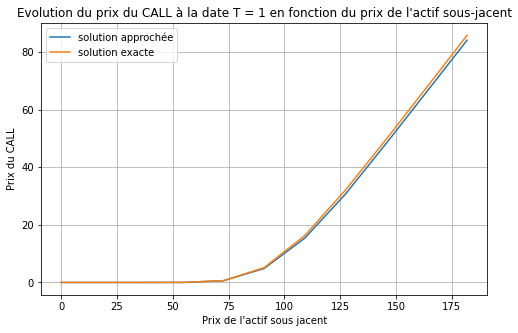

In [14]:
#-------------------------------------------------
#- DONNEES
#-------------------------------------------------
# Constantes
K = 100
sigma = 0.2
r = 0.04
T = 1
Smax = 200

#- Condition initale (Payoff)
def P0(s):
    if (OPTION=='PUT'):
        return np.maximum(K - s, [0]*len(s))
    elif (OPTION=='CALL'):
        return np.maximum(s - K, [0]*len(s))
    else:
        print('Vérifier la variable OPTION')

#- Variables d'entrée
M=int(input('Nombre de points de discrétisation en espace M = '))
NB_SIMU = int(input("Nombre de simulations \n  "))
OPTION = str(input("CALL ou PUT \n  "))
# METHODE=str(input("NAIF ou ANT \n  "))
METHODE = "NAIF"
        
#-------------------------------------------------
#- FORMULE DE BLACK SCHOLES : SOLUTION EXACTE
#-------------------------------------------------
def U_exacte(t, s):
    if t==0:
        return P0(s)
    else:
        P=np.ones(len(s))*K*np.exp(-r*t)
        i=np.where(s>0) 
        tau=sigma**2*t
        dm=(np.log(s[i] /K) + r*t - 0.5*tau) / np.sqrt(tau)
        dp=(np.log(s[i] /K) + r*t + 0.5*tau) / np.sqrt(tau)
        P[i]=K*np.exp(-r*t)*(norm.cdf(-dm)) - s[i]*(norm.cdf(-dp))
        if (OPTION=='PUT'):
            return P
        elif (OPTION=='CALL'):
            return s + P - K*np.exp(-r*t)
        else:
            print('Vérifier la variable OPTION')
            
#-------------------------------------------------
#- MAILLAGE
#-------------------------------------------------
h=Smax/(M+1)
s=np.arange(0,M+1)*h
        
#-------------------------------------------------
#- MONTE CARLO
#-------------------------------------------------
def MC_naif(S0, K, T, r, sigma, X):
    muT = (r-0.5*sigma**2)*T
    sigmaT = sigma*np.sqrt(T)
    ST = S0*np.exp(muT + sigmaT*X)
    if (OPTION=='PUT'):
        return np.mean(np.exp(-r*T)*np.maximum(K-ST, [0]*NB_SIMU))
    elif (OPTION=='CALL'):
        return np.mean(np.exp(-r*T)*np.maximum(ST-K, [0]*NB_SIMU))

#-------------------------------------------------
#- SOLUTION APPROCHEE
#-------------------------------------------------

#- Une fois
start = time.time()

U_approx = np.zeros(M+1)
U_ex = U_exacte(T,s)
X = np.random.normal(0, 1, NB_SIMU)
for j in range(M+1):
    if (METHODE=='NAIF'):
        U_approx[j] = MC_naif(s[j], K, T, r, sigma, X)
#     elif (METHODE=='ANT'):
#         U_approx[j] = MC_ant(s[j], K, T, r, sigma, X)

end = time.time()

print("Erreur Linf à la date T=1 : ", np.max(np.abs(U_approx - U_ex)))
print("Temps écoulé : ", end - start)

#- 1000 fois
start = time.time()

U_final = np.zeros(M+1)
U_ex = U_exacte(T,s)
errLI = 0
for i in range(1000):
    U_approx = np.zeros(M+1)
    X = np.random.normal(0, 1, NB_SIMU)
    for j in range(M+1):
        if (METHODE=='NAIF'):
            U_approx[j] = MC_naif(s[j], K, T, r, sigma, X)
    #     elif (METHODE=='ANT'):
    #         U_approx[j] = MC_ant(s[j], K, T, r, sigma, X)
    U_final += U_approx
    errLI += np.max(np.abs(U_approx - U_ex))
U_final = U_final/1000
errLI = errLI/1000

end = time.time()

print("Erreur moyenne Linf à la date T=1 : ", errLI)
print("Temps moyen écoulé : ", (end - start)/1000)

#-------------------------------------------------
#- GRAPHIQUES
#-------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(s, U_approx, label='solution approchée')
plt.plot(s, U_ex, label='solution exacte')
plt.title("Evolution du prix du "+OPTION+" à la date T = "+str(T)+" en fonction du prix de l'actif sous-jacent")
plt.xlabel("Prix de l'actif sous jacent")
plt.ylabel("Prix du "+OPTION)
plt.grid()
plt.legend()
plt.show()

#-------------------------------------------------
#- COMPARAISON DES METHODES
#-------------------------------------------------
# ErrNAIF = np.zeros(1000)
# ErrANT = np.zeros(1000)
# for n in range(1000):
#     X = np.random.normal(0, 1, nb_simu)
#     NAIF = np.zeros(M+1)
#     ANT = np.zeros(M+1)
#     for j in range(M+1):
#         NAIF[j] = MC_naif(s[j], K, T, r, sigma, X)
#         ANT[j] = MC_ant(s[j], K, T, r, sigma, X)
#     ErrNAIF[n] =  np.max(np.abs(NAIF - U_ex))
#     ErrANT[n] =  np.max(np.abs(ANT - U_ex))
# print('Variance pour NAIF ', np.var(ErrNAIF))

### Comparaison des méthodes

| Erreur $L_{\infty}$ avec $M=50$ et $N=800$ et un nombre de simulations de $40 000$ pour le MC | DF        | EF        | MC        |
|-----------------------------------------------------------------------------------------------|-----------|-----------|-----------|
| EE + CENTRE                                                                                   | 1.10 e-02 | 2.59 e-02 | 6.47 e-02 |
| EE + DROIT                                                                                    | 1.51 e-01 |           |           |
| EE + GAUCHE                                                                                   | 1.54 e-01 |           |           |
| EI + CENTRE                                                                                   | 1.28 e-02 | 2.34 e-02 |           |
| EI + DROIT                                                                                    | 1.49 e-01 |           |           |
| EI + GAUCHE                                                                                   | 1.56 e-01 |           |           |
| CN + CENTRE                                                                                   | 1.19 e-02 | 2.47 e-02 |           |
| CN + DROIT                                                                                    | 1.50 e-01 |           |           |
| CN + GAUCHE                                                                                   | 1.55 e-01 |           |           |

| Temps écoulé (en sec) avec $M=50$ et $N=800$ et un nombre de simulations de $40 000$ pour le MC | DF        | EF   | MC        |
|-------------------------------------------------------------------------------------------------|-----------|------|-----------|
| EE + CENTRE                                                                                     | 1.66 e-01 | 1.1  | 1.23 e-01 |
| EE + DROIT                                                                                      | 1.58 e-01 |      |           |
| EE + GAUCHE                                                                                     | 1.62 e-01 |      |           |
| EI + CENTRE                                                                                     | 1.61      | 1.01 |           |
| EI + DROIT                                                                                      | 1.12      |      |           |
| EI + GAUCHE                                                                                     | 1.56      |      |           |
| CN + CENTRE                                                                                     | 1.17      | 1.03 |           |
| CN + DROIT                                                                                      | 1.05      |      |           |
| CN + GAUCHE                                                                                     | 1.15      |      |           |